* http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
* https://github.com/ampleforth/ampleforth-contracts/blob/master/contracts/UFragments.sol
* https://medium.com/@marcilgen_70414/rebasing-tokens-with-oracles-and-liquidity-mining-the-ampleforth-approach-as-a-precursor-to-fdec8f83a0bb

In [1]:
import uuid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from matplotlib import rc

In [2]:
TYPE_TREASURY_TOKEN = 'TREASURY'
TYPE_DEBT_TOKEN = 'DEBT'
TYPE_COLLATERAL_TOKEN = 'COLLATERAL'
TYPE_DEPOSIT_TOKEN = 'DEPOSIT'

In [3]:
DECIMALS = 6
MAX_UINT256 = (2**128) - 1
INITIAL_FRAGMENTS_SUPPLY = 50 * 10**6 * 10**DECIMALS
TOTAL_GONS = MAX_UINT256 - (MAX_UINT256 % INITIAL_FRAGMENTS_SUPPLY)
MAX_SUPPLY = MAX_UINT256

class TokenSupply():

    def __init__(self):
        self.__total_supply = float(INITIAL_FRAGMENTS_SUPPLY)
        self.__gons_per_frag = float(TOTAL_GONS)/float(MAX_SUPPLY)
        
    def get_max_supply(self):
        return self.__total_supply
    
    def get_total_supply(self):
        return self.__total_supply
    
    def set_total_supply(self, total_supply):
        self.__total_supply = total_supply    

    def get_gons_per_fragment(self):
        return self.__gons_per_frag
    
    def rebase(self, delta):

        if (delta < 0):
            self.__total_supply = self.__total_supply - abs(delta)
        else:
            self.__total_supply = self.__total_supply + abs(delta);
             
        self.__gons_per_frag = TOTAL_GONS/self.__total_supply;
        
        if (self.__total_supply > MAX_SUPPLY): 
            self.__total_supply = MAX_SUPPLY
        
        return self.__total_supply

class TokenAddress():   
    
    def __init__(self, gons_per_frag = None):
        self.__gon_balances = {} 
        self.__gons_per_frag = gons_per_frag
        
    def set_gons_per_fragment(gons_per_frag):
        self.__gons_per_frag = gons_per_frag
    
    def get_balance(self, user_address):
        return self.__gon_balances[user_address]/self.__gons_per_frag
    
    def gen_key(self):
        uid = uuid.uuid4()
        return uid.hex
    
    def get_balances(self):
        return self.__gon_balances
    
    def address_exist(self, address):
        return address in self.__gon_balances.keys()
    
    def set_address(self, user_address):
        self.__gon_balances[user_address] = 0
    
    def set_balance(self, balance, user_address):
        self.__gon_balances[user_address] = balance/self.__gons_per_frag
        
    def delta_balance(self, delta, user_address):
        gon_delta = delta/self.__gons_per_frag
        
        self.__gon_balances[user_address] = self.__gon_balances[user_address] + gon_delta  
        
class Token():
    
    def __init__(self, name, supply = None, addresses = None):
        self.__tname = name
        self.__supply = TokenSupply() if supply == None else supply
        self.__addresses = TokenAddress(self.__supply.get_gons_per_fragment()) if addresses == None else addresses
               
    def set_token(self, token):
        self.__tname = token.get_name()
        self.__supply = token.get_supply()
        self.__addresses = token.get_addresses()
        
    def get_addresses(self):
        return self.__addresses
    
    def get_supply(self):
        return self.__supply    
    
    def get_rate(self):
        return self.__native_rate    
      
    def get_name(self):
        return self.__tname       
    
    def set_rate(self, native_rate):
        self.__native_rate = native_rate 
        
    def set_addresses(self, addresses):
        self.__addresses = addresses
        
    def set_total_supply(self, total_supply):
        return self.__supply.set_total_supply(total_supply)       

    def gen_address(self):
        return self.__addresses.gen_key()
    
    def deposit(self, delta, address):
        
        if(not self.__addresses.address_exist(address)):
            self.__addresses.set_balance(delta, address)
        else:    
            self.__addresses.delta_balance(delta, address)
            
        self.__supply.rebase(delta)     
    
    def rebase(self, delta):
        self.__supply.rebase(delta)    

class Convert(): 
    def __init__(self, native_rate):
        self.__native_rate = native_rate
    
    def apply(self,token_delta):
        return self.__native_rate*token_delta
            
class Swap(Token): 
    
    def __init__(self, token, native_rate, address = None):
        super().__init__(token.get_name(), token.get_supply(), token.get_addresses())
        self.__native_rate = native_rate
        self.__address = address if token.get_rate().gen_key() == None else address
     
    def apply(self, token, token_delta, address):
        token_balance = token.get_addresses().get_balance(address)
        balance = self.__native_rate*token_delta  
        super().set_balance(balance, self.__address)
        token.set_balance(balance-token_delta, address)

class TokenMap(): 
    
    def __init__(self, ttype = None):
        self.__ttype = ttype
        self.__map = {} 
        
    def get_map(self):
        return self.__map
        
    def append_token(self, name, token):        
        self.__map[name] = token

class AggregateTokenMap(Token):
    
    def __init__(self, name, token_map = TokenMap()):
        super().__init__(name, None, None)
        self.__token_map = token_map
        self.__aggregate_supply = 0
        
    def apply(self):
        token_map = self.__token_map.get_map()
        for key in token_map:
            supply = token_map[key].get_supply().get_total_supply()
            self.__aggregate_supply = self.__aggregate_supply + supply
        super().set_total_supply(self.__aggregate_supply)    
     
            

In [11]:
dToken = Token(TYPE_DEBT_TOKEN)

depositToken1 = Token(TYPE_DEPOSIT_TOKEN)
depositToken2 = Token(TYPE_DEPOSIT_TOKEN)
depositTokenMap = TokenMap(TYPE_DEPOSIT_TOKEN)

cToken1 = Token(TYPE_COLLATERAL_TOKEN)
cToken2 = Token(TYPE_COLLATERAL_TOKEN)
cTokenAddr1 = cToken1.gen_address()
cTokenAddr2 = cToken2.gen_address()
cTokenMap = TokenMap(TYPE_COLLATERAL_TOKEN)

dToken1 = Token(TYPE_DEBT_TOKEN)
dToken2 = Token(TYPE_DEBT_TOKEN)
dTokenAddr1 = dToken1.gen_address()
dTokenAddr2 = dToken2.gen_address()
dTokenMap = TokenMap(TYPE_DEBT_TOKEN)

tradeDebtToken1 = Token(TYPE_DEBT_TOKEN)
tradeDebtToken2 = Token(TYPE_DEBT_TOKEN)
tradeDebtAddr1 = tradeDebtToken1.gen_address()
tradeDebtAddr2 = tradeDebtToken2.gen_address()
tradeDebtTokenMap1 = TokenMap(TYPE_DEBT_TOKEN)
tradeDebtTokenMap2 = TokenMap(TYPE_DEBT_TOKEN)

for k in range(25):

    dTokenPrev = dToken

    # setup deposit probabilities
    deposit1 = deposit2 = 0.0
    select = np.random.choice(3, 1, p=[0.25, 0.25, 0.5])[0]

    if(select == 0): 
        # deposit first token only with 25% probability
        deposit1 = np.random.gamma(2, 10, 1)[0]
    elif (select == 1):
        # deposit second token only with 25% probability
        deposit2 = np.random.gamma(2, 10, 1)[0]
    else:
        # deposit both tokens with 50% probability
        deposit1 = np.random.gamma(2, 10, 1)[0]
        deposit2 = np.random.gamma(2, 10, 1)[0]

    nativeDeposit1 = Convert(1.0).apply(deposit1) 
    nativeDeposit2 = Convert(1.0).apply(deposit2) 

    depositTokenAddr1 = depositToken1.gen_address()
    depositTokenAddr2 = depositToken2.gen_address()
    depositToken1.deposit(nativeDeposit1, depositTokenAddr1)
    depositToken2.deposit(nativeDeposit2, depositTokenAddr2)

    # Collateral tokens
    cToken1.deposit(nativeDeposit1, cTokenAddr1)
    cToken2.deposit(nativeDeposit2, cTokenAddr2)

    cTokenPool = TokenMap(TYPE_COLLATERAL_TOKEN)
    cTokenPool.append_token('TCT1', cToken1)
    cTokenPool.append_token('TCT2', cToken2)

    cToken = AggregateTokenMap(TYPE_COLLATERAL_TOKEN, cTokenPool)
    cToken.apply()
    cTokenMap.append_token('event'+str(k), cToken)

    # Debt tokens
    dToken1.deposit(nativeDeposit1, dTokenAddr1)
    dToken2.deposit(nativeDeposit2, dTokenAddr2)    

    dTokenPool = TokenMap(TYPE_DEBT_TOKEN)
    dTokenPool.append_token('TDT1', cToken1)
    dTokenPool.append_token('TDT2', cToken2)

    dToken = AggregateTokenMap(TYPE_DEBT_TOKEN, cTokenPool)
    dToken.apply()
    dTokenMap.append_token('event'+str(k), dToken)

    # Trade off deposit tokens for debt token
    toDebt1 = Convert(3).apply(deposit1)
    toDebt2 = Convert(3).apply(deposit2) 
    
    tradeDebtToken1.deposit(toDebt1, tradeDebtAddr1)
    tradeDebtToken2.deposit(toDebt2, tradeDebtAddr2) 

    #print('{:.30f}'.format(cToken.get_supply().get_total_supply()))

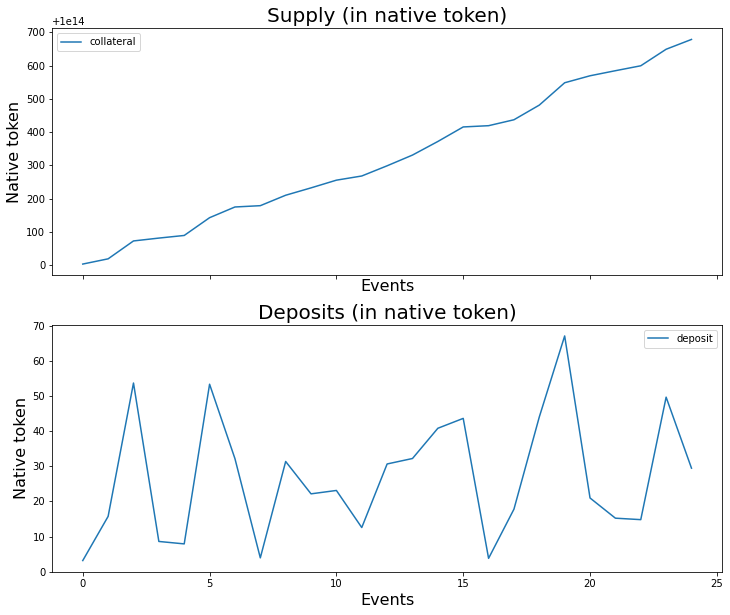

In [12]:
cmap = cTokenMap.get_map()

T1_deposits = depositToken1.get_addresses().get_balances()
T2_deposits = depositToken2.get_addresses().get_balances()
T1_deposits = [T1_deposits[token] for token in T1_deposits]
T2_deposits = [T2_deposits[token] for token in T2_deposits]

tSamp = list(range(len(cmap)))
collateral = [cmap[token].get_supply().get_total_supply() for token in cmap]
deposits = [T2_deposits[k] + T1_deposits[k] for k in range(len(T1_deposits))]

fig, (cum_ax, dep_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))
cum_ax.plot(tSamp, collateral, label='collateral') 
cum_ax.set_title("Supply (in native token)", fontsize=20)
cum_ax.set_ylabel("Native token", fontsize=16)
cum_ax.set_xlabel('Events', fontsize=16)
cum_ax.legend()

dep_ax.plot(tSamp, deposits, label='deposit') 
dep_ax.set_title("Deposits (in native token)", fontsize=20)
dep_ax.set_ylabel("Native token", fontsize=16)
dep_ax.set_xlabel('Events', fontsize=16)
dep_ax.legend()


In [6]:
class ConstantProductTrade():
    
    def __init__(self, pa, pb, L):
        self.__pnt_a = pa 
        self.__pnt_b = pb
        self.__L = L
 
    def set_pa(self, pa):
        self.__pnt_a = pa
        
    def set_pb(self, pb): 
        self.__pnt_b = pb
        
    def set_L(self, L):  
        self.__L = L

    def f(self, x):
        return self.__L**2/x;

    def x_p(self, p):
        return self.__L/(p ** 0.5)

    def y_p(self, p):
        return self.__L*(p ** 0.5)

    def pnt_p(self, p):
        return (self.x_p(self.__L,p), self.y_p(self.__L,p))

    def x_max(self):
        x_pa = self.x_p(self.__pnt_a)
        x_pb = self.x_p(self.__pnt_b)
        return abs(x_pa - x_pb)

    def y_max(self):
        y_pa = self.x_p(self.__pnt_a)
        y_pb = self.x_p(self.__pnt_b)
        return abs(y_pa - y_pb)  
    
    def execution_price(self, delta_x, delta_y):
        return delta_y/delta_x

    def swap(self, x_swap, price):
        return price*x_swap

    def random_swap(self, max_trade = 1):
        shape, scale = 1, max_trade/5
        trade = np.random.gamma(shape, scale, 1)
        return min(trade[0],max_trade)

    def price_swap_x(self, p, del_x, L):
        a = p
        b = -p*del_x
        c = -L**2 
        return (-b + (b**2 - 4*a*c)**0.5)/(2*a)    
    

In [13]:
deposit1 = depositToken1.get_addresses().get_balances()

In [8]:
p = 2
L = 100
price_factor = 3
pa = p/price_factor
pb = p*price_factor
bound = price_factor*L
d = 0.1

cpt = ConstantProductTrade(pa,pb,L)

x_max = cpt.x_max(); y_max = cpt.y_max()
x_pa = cpt.x_p(pa); y_pa = cpt.y_p(pa)
x_pb = cpt.x_p(pb); y_pb = cpt.y_p(pb)

In [14]:
x_shift = 0.001
x_real = np.arange(x_shift, bound, 0.001)
x_virt = np.arange(x_shift, bound, 0.001)

x_pa = cpt.x_p(pa); y_pa = cpt.y_p(pa)
x_pb = cpt.x_p(pb); y_pb = cpt.y_p(pb)

y_virt = L**2/x_virt
y_real = L**2/(x_real+L/np.sqrt(pb)) - L*np.sqrt(pa)

fig, ax = plt.subplots(figsize=(8, 8))

line1, = ax.plot([],[], 'go', label='T1/TDT trades')
line2, = ax.plot([],[], 'r--',lw=0.5, label='max')
line3, = ax.plot([],[], 'r--',lw=0.5)
line4, = ax.plot([],[], 'g--',lw=0.5, label='price trade line')

plt.plot(x_virt, y_virt, label='virtual') 
plt.plot(x_real, y_real, label='real')
ax.set_xlabel('TDT')
ax.set_ylabel('T1')
ax.set_ylim(0, 1.5*y_pb)
ax.set_xlim(0, 1.5*x_pa)
txt_title = ax.set_title('')
ax.legend();
plt.close(1)

T1_swap = list(deposit1.values())

x_swap = []; y_swap = []

def animate(i,factor):
    
    #delta_x_swap = cpt.random_swap(x_max)
    delta_x_swap = T1_swap[i]
    x = cpt.price_swap_x(p, delta_x_swap, L)
    
    x_swap.append(x)
    y_swap.append(p*x)
    
    line1.set_xdata(x_swap[:i])
    line1.set_ydata(y_swap[:i])
    
    line2.set_xdata([x_pb,x_pa])
    line2.set_ydata([y_pb,y_pb])
    
    line3.set_xdata([x_pa,x_pa])
    line3.set_ydata([y_pb,y_pa])   
    
    line4.set_xdata([0,x_pa])
    line4.set_ydata([0,y_pb])     
    
    txt_title.set_text('Swap = {0:4d}'.format(i))
    return line1,line2,line3,line4


In [15]:
K = 0.75 # any factor 
anim = animation.FuncAnimation(fig, animate, frames=25, fargs=(K,),
                              interval=500, blit=True)

rc('animation', html='html5')

anim